# Simulating a System of Patchy Particles

## Overview

### Questions
* How do I implement pairwise energetic interactions in HPMC?

### Objectives
* Run a simulation of particles interacting through the Kern–Frenkel pair potential.
* Log the potential energy during an HPMC simulation.

## Boilerplate Code

In [1]:
import os

for _fn in ['initial.gsd', 'log.gsd']:
    fn = os.path.join(os.getcwd(), _fn)
    ![ -e "$fn" ] && rm "$fn"

In [2]:
import itertools
import math

import gsd.hoomd
import hoomd
import matplotlib
import matplotlib_inline
import numpy

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In the previous section, you learned about patchy particles and the Kern–Frenkel model.
In this section, you will initialize a system of particles, add the Kern–Frenkel pair potential to the simulation, and run the simulation while logging the energy.

## Constructing the System
Construct the system using the same code you used in [Introducing HOOMD-blue tutorial](../00-Introducing-HOOMD-blue/03-Initializing-the-System-State.ipynb) and then initialize a simulation.

In [3]:
m = 4
N_particles = 2 * m**3
spacing = 1.2
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = position[0:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

# gsd snapshot
snapshot = gsd.hoomd.Frame()
snapshot.particles.N = N_particles
snapshot.particles.position = position
snapshot.particles.orientation = orientation
snapshot.particles.typeid = [0] * N_particles
snapshot.particles.types = ['A']
snapshot.configuration.box = [L, L, L, 0, 0, 0]
with gsd.hoomd.open(name='initial.gsd', mode='x') as f:
    f.append(snapshot)

# build simulation
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=0)
simulation.create_state_from_gsd(filename='initial.gsd')

### Define Interaction Parameters
Define the parameters $\delta$, $\varepsilon$, $\lambda$, and $\sigma$ of the Kern–Frenkel model to simulate.

In [4]:
delta = math.pi / 4
epsilon = 1.0 / 3.0
lambda_ = 1.2
sigma = 1.0

### Add HPMC Integrator

Use the `Sphere` HPMC integrator to implement the hard core portion of the Kern-Frenkel interaction potential.
HPMC does not apply rotation moves to spheres by default.
Set the `orientable` key to `True` so that HPMC will rotate the particles.

In [5]:
mc = hoomd.hpmc.integrate.Sphere()
mc.shape['A'] = dict(diameter=sigma, orientable=True)
simulation.operations.integrator = mc

## Add the Pair Potential

HOOMD-blue represents the Kern-Frenkel potential as a product of an isotropic potential and an orientation dependent mask.
The isotropic potential depends only on distance and the orientation dependent mask depends only on the relative position and orientation.

$$
U_{ij} = U_\mathrm{isotropic}(r_{ij}) \cdot U_\mathrm{angular}(\vec{r}_{ij}, \mathbf{q}_i, \mathbf{q}_j)
$$

### Step Potential

Represent the isotropic part of the Kern-Frenkel potential with a **Step** potential:

In [6]:
step = hoomd.hpmc.pair.Step()
step.params[('A', 'A')] = dict(epsilon=[-epsilon], r=[lambda_ * sigma])

**Step** can represent any step-wise function of *r*.
The parameters above set the $-\varepsilon$ attractive energy when $r_{ij} < \lambda_{ij}\sigma_{ij}$ and 0 energy when $r_{ij} \geq \lambda_{ij}\sigma_{ij}$.

### Angular Step Potential

Mask the isotropic step potential with an angular dependent factor computed by **AngularStep**:

In [7]:
angular_step = hoomd.hpmc.pair.AngularStep(isotropic_potential=step)
angular_step.mask['A'] = dict(directors=[(1.0, 0, 0)], deltas=[delta])

A director is a unit vector pointing to the position of the patch in the *particle's local coordinates*.
$\vec{e}_i$ in the previous section is the director rotated into the system's coordinate system.
**AngularStep** can evaluate potentials that have multiple patches with different sizes.
This section adds one patch to implement the Kern-Frenkel potential.

### Evaluating the Patchy Potential when Integrating

The HPMC integrator will evaluate all pair potentials in its `pair_potentials` attribute when making trial moves.
Add `angular_step` to this list:

In [8]:
mc.pair_potentials = [angular_step]

You can query the energy associated with the patch potential via the `energy` property of the angular step object (after running for 0 or more steps).
The particles are not interacting in the initial configuration, and hence the initial value of the energy is zero.

In [9]:
simulation.run(0)
angular_step.energy

0.0

### Log the Patch Energy

Use a `Logger` to write the total system potential energy to a `GSD` file.

In [10]:
logger = hoomd.logging.Logger()
logger.add(
    mc,
    quantities=['pair_energy'],
)
gsd_writer = hoomd.write.GSD(
    filename='log.gsd',
    trigger=hoomd.trigger.Periodic(10),
    mode='xb',
    filter=hoomd.filter.Null(),
    logger=logger,
)
simulation.operations.writers.append(gsd_writer)

## Run the Simulation

### Randomize the System

The initial `epsilon` value set above is small enough that the particles weakly attract.
Run the simulation to randomize the particle degrees of freedom:

In [11]:
simulation.run(500)

### Increase the Interaction Strength

Increase the interaction strength and run the simulation longer.
The particles will form clusters:

In [12]:
step.params[('A', 'A')]['epsilon'] = [-10]
simulation.run(2000)

Decrease the interaction strength and the clusters will break apart.

In [13]:
step.params[('A', 'A')]['epsilon'] = [-1.0 / 3.0]
simulation.run(2000)

As discussed in the [Logging tutorial](../02-Logging/02-Saving-Array-Quantities.ipynb), flush the write buffer (this is not necessary in typical workflows).

In [14]:
gsd_writer.flush()

## Analyzing the Results

Use the `gsd` package to read the logged values:

In [15]:
data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']
potential_energy = data['log/hpmc/integrate/Sphere/pair_energy']

Plot the energy as a function of timestep:

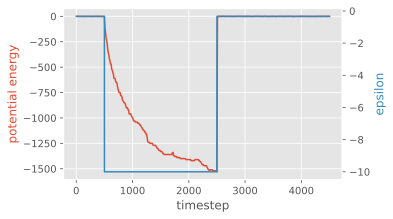

In [16]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
(ll,) = ax.plot(step, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy', c=ll.get_c())

ax2 = ax.twinx()
ax2.grid(False)
ax2._get_lines.get_next_color()
(ll,) = ax2.plot(
    [0, 500, 501, 2500, 2501, 4500], [-1 / 3, -1 / 3, -10, -10, -1 / 3, -1 / 3]
)
ylabel = ax2.set_ylabel('epsilon', c=ll.get_c())

fig

The decrease in energy when epsilon was set to -10 indicates particle clustering. 

## Summary

In this tutorial, you learned about patchy particles and the Kern–Frenkel model of patchy particles and implemented the Kern–Frenkel model in HPMC.

For more information on simulating patchy particles, or more generally HPMC simulations with energetic interactions, see the HOOMD-blue documentation on pair potentials in HPMC.